In [2]:
! hostname
! whoami
! pwd
# ! nvidia-smi

dhcp-10-29-100-233.dyn.mit.edu
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
from tqdm.auto import tqdm
import cv2
import os
import re
from tqdm.auto import tqdm
import time

from IPython.display import clear_output


import gym
import procgen
from procgen import ProcgenEnv

In [5]:
import env_utils
import models
import ppo_rnd
import train
import pretrain
import bc

# Time tests

In [6]:
env = ProcgenEnv(64, 'miner', distribution_mode='easy')
env.reset();

building procgen...done


In [9]:
%%time

n_steps = 10000
start = time.time()
for i in range(n_steps):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
sps = (n_steps*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS: 152644.34
CPU times: user 10.8 s, sys: 2.26 s, total: 13.1 s
Wall time: 4.19 s


In [520]:
obss = torch.zeros(256, 64, *env.observation_space['rgb'].shape, dtype=torch.uint8)
dones = torch.zeros(256, 64, dtype=torch.bool)
for i in range(256):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
    obss[i] = torch.from_numpy(obs['rgb'])
    dones[i] = torch.from_numpy(done)

In [532]:
a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
a.shape

torch.Size([255, 64, 64, 64])

In [546]:
mask_start = torch.zeros(64, 64, 64, dtype=torch.bool)
mask_eps = mask_start
for t in range(255):
    mask_eps = mask_eps | a[t]
    mask_eps[dones[t]] = mask_start[dones[t]]

In [13]:
import gym
from ppo_procgen import VecMinerEpisodicCoverageReward, StoreObs, ReturnTracker

def make_env(obj, num_envs, env_id, num_levels, start_level, distribution_mode, gamma):
    envs = ProcgenEnv(num_envs=num_envs, env_name=env_id, num_levels=num_levels,
                      start_level=start_level, distribution_mode=distribution_mode)
    envs = gym.wrappers.TransformObservation(envs, lambda obs: obs["rgb"])
    envs.observation_space = envs.observation_space['rgb']
    envs.single_action_space = envs.action_space
    envs.single_observation_space = envs.observation_space
    envs.is_vector_env = True
    envs = gym.wrappers.RecordEpisodeStatistics(envs)
    # envs = StoreObs(envs)
    # envs = VecMinerEpisodicCoverageReward(envs, obj)
    # envs = ReturnTracker(envs)
    envs = gym.wrappers.NormalizeReward(envs, gamma=gamma)
    envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))
    return envs



In [29]:
env = make_env('eps', 64, 'fruitbot', 10, 0, 'hard', 0.99)
env.reset();

In [30]:
n_steps = 1000
start = time.time()
for i in range(n_steps):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
sps = (n_steps*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS:  84650.95


ProcgenMiner Easy

ProcGen: 156K

ProcGen + default wrappers: 140K

Procgen + default wrappers + StoreObs: 134K

Procgen + default wrappers + StoreObs + VecMinerEpisodicCoverage: 17K


In [106]:
from ppo_procgen import Agent
agent = Agent(env).to('mps')

In [107]:
x = torch.randint(low=0, high=255, size=(64, 64, 64, 3), dtype=torch.uint8)
x = x.to('mps')
x.shape, x.dtype

(torch.Size([64, 64, 64, 3]), torch.uint8)

In [108]:
start = time.time()
for i in range(256):
    with torch.no_grad():
        agent.get_value(x)
sps = (256*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS:  27497.13


In [100]:
env = make_env('eps', 64, 'miner', 10, 0, 'easy', 0.99)
env.reset();

ff


In [119]:
n_steps = 1000
obss = torch.zeros(n_steps, env.num_envs, *env.observation_space.shape, dtype=torch.uint8)
dones = torch.zeros(n_steps, env.num_envs, dtype=torch.bool)
start = time.time()
for i in range(n_steps):
    action = np.array([env.action_space.sample() for _ in range(env.num_envs)])
    obs, rew, done, info = env.step(action)
    obss[i] = torch.from_numpy(obs)
    dones[i] = torch.from_numpy(done)
    
# mask_start = torch.zeros(64, 64, 64, dtype=torch.bool)
# mask_eps = mask_start
# a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
# for t in range(255):
#     mask_eps = mask_eps | a[t]
#     mask_eps[dones[t]] = mask_start[dones[t]]
    
sps = (n_steps*env.num_envs)/(time.time()-start)
print(f'SPS: {sps:9.2f}')

SPS:  17654.39


In [149]:
%%time
mask_start = torch.zeros(64, 64, 64, dtype=torch.bool)
mask_eps = mask_start
# a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
b = (obss[1:]!=obss[:-1]).any(dim=-1)
# for t in range(255):
#     mask_eps = mask_eps | a[t]
#     mask_eps[dones[t]] = mask_start[dones[t]]

CPU times: user 547 ms, sys: 199 ms, total: 745 ms
Wall time: 96.8 ms


In [115]:
%%time
obss = obss.to('mps')
dones = dones.to('mps')

mask_start = torch.zeros(64, 64, 64, dtype=torch.bool, device='mps')
mask_eps = mask_start
a = ((obss[1:]-obss[:-1]).abs()>1e-3).any(dim=-1)
for t in range(255):
    mask_eps = mask_eps | a[t]
    mask_eps[dones[t]] = mask_start[dones[t]]

CPU times: user 48.2 ms, sys: 2.69 s, total: 2.74 s
Wall time: 4.14 s


In [166]:
a = obss.cpu()

In [167]:
%%timeit
(a[1:]!=a[:-1]).any(dim=-1);

94.4 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [179]:
a = obss.to('mps:1')

In [187]:
%%time
(a[1:]!=a[:-1]).any(dim=-1);

CPU times: user 14.3 ms, sys: 13.8 ms, total: 28.1 ms
Wall time: 18.4 ms


In [213]:
from ppo_procgen import Agent
agent = Agent(env)

In [222]:
for name, p in agent.named_parameters():
    if name.startswith('critic'):
        p.requires_grad_(False)


In [134]:
os = np.stack(os)[:, 0]
rs = np.array(rs)[:, 0]
os.shape, rs.shape

((100, 64, 64, 3), (100,))

In [135]:
# os[rs==1., :, :, 0] = 0.

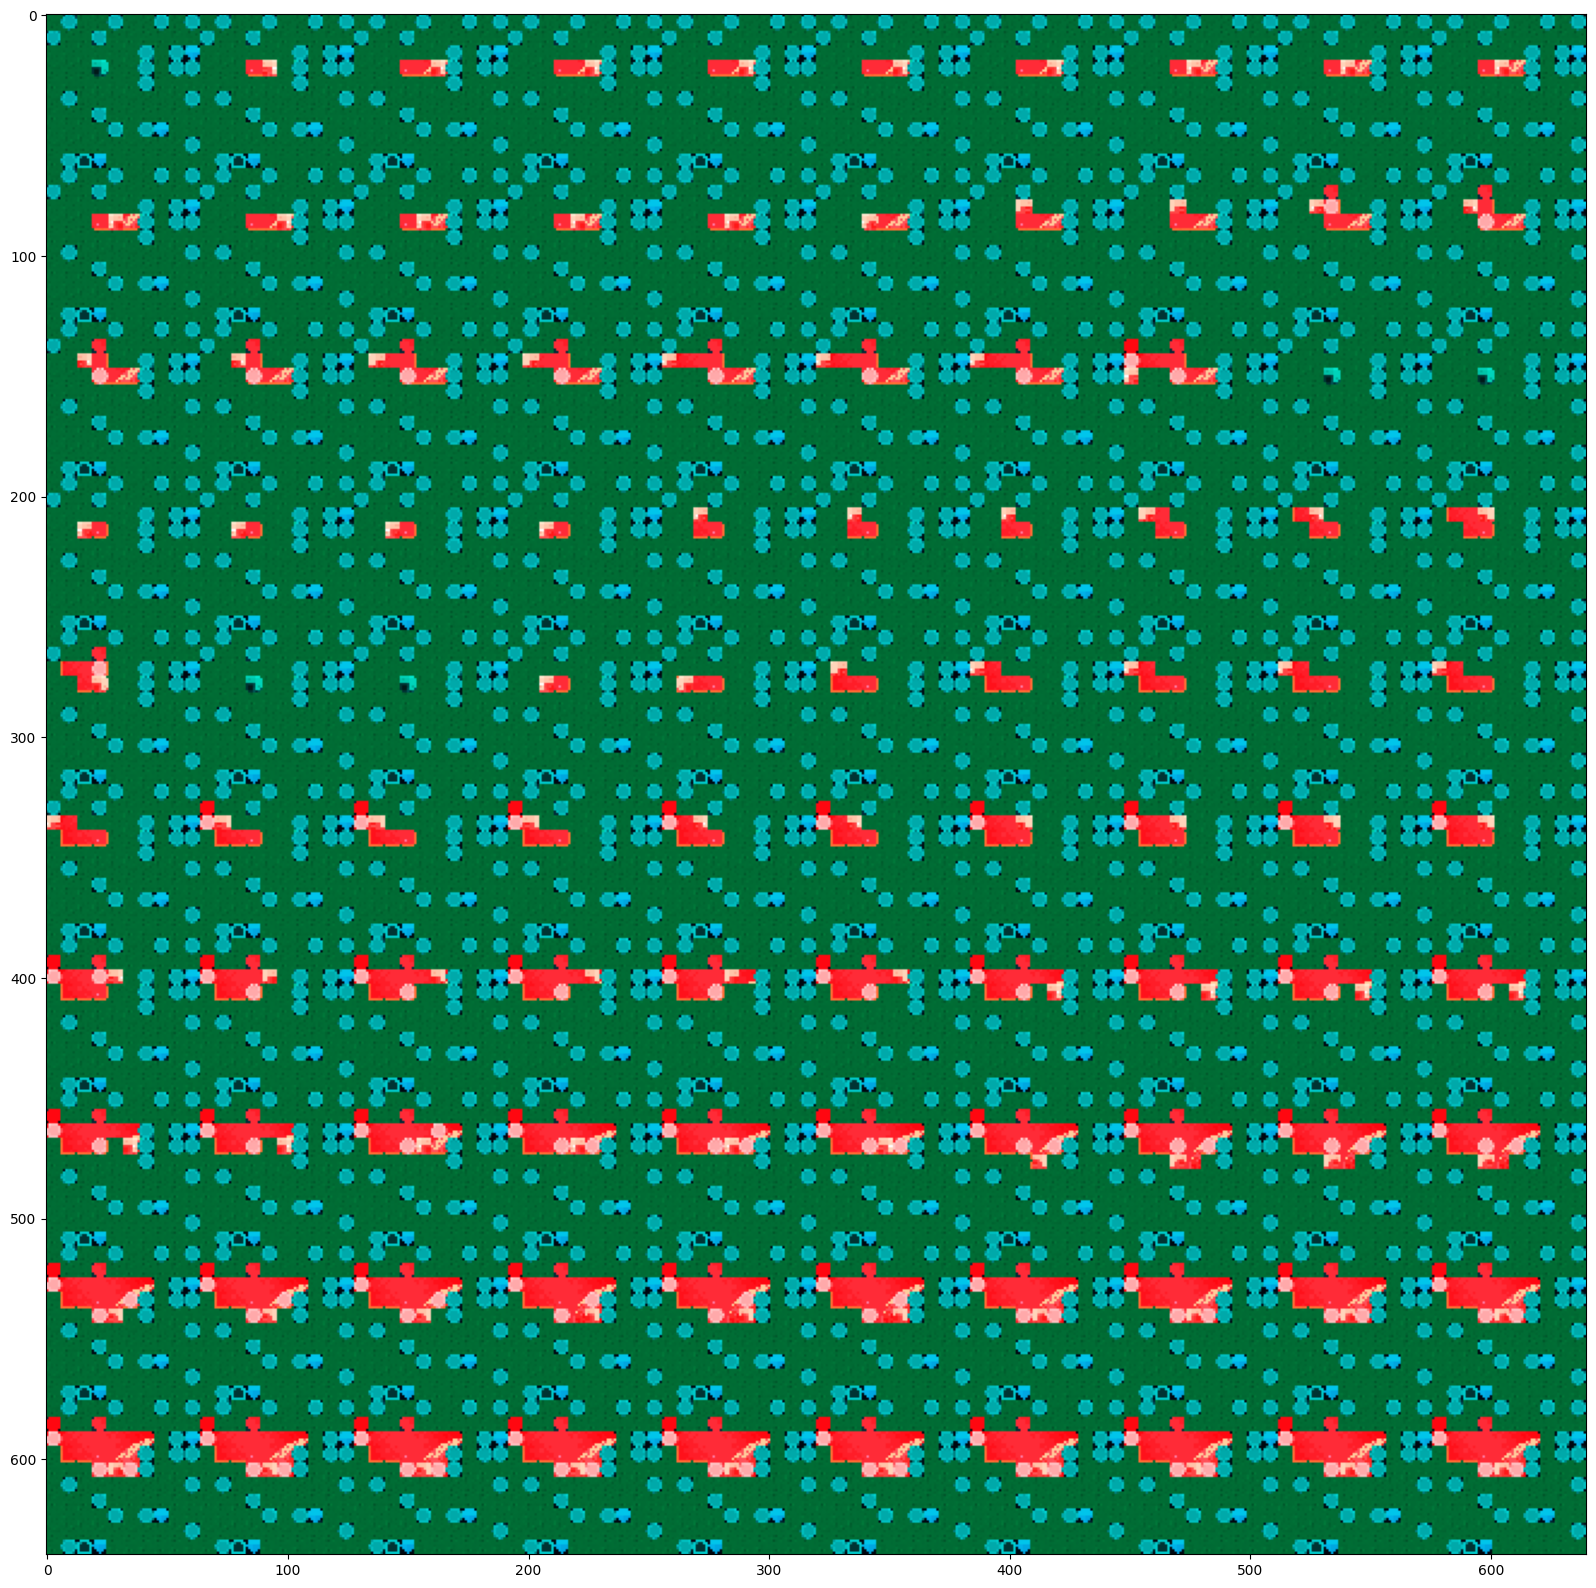

In [136]:
plt.figure(figsize=(20, 20))
a = rearrange(os, '(H W) h w c -> (H h) (W w) c', H=10)
plt.imshow(a)